# Train an LSTM classifier on fMRI activity of visual regions of the brain to predict type of visual stimuli

Here, we will train a simple LSTM to predict which type of image was seen based on the brain activity of visual regions. For the first pass, we will simply classify whether the image came from ImageNet, COCO, or SUN. These databses have distinct types of images: focused single object, naturalistic objects, environmental scenes, respectively.

We will train a separate LSTM for each of the ten brain regions that were extracted from each subject viewing these images. Perhaps we will find that in isolation neither region provides enough information to successfully classify, or one or two region will have particular higher accuracies. Whatever result we find will dictate how we proceed next. Maybe we can train combining all regions into one large training set, or use stacked LSTMs or hierarchical LSTMs. Let's find out using Keras.

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import os

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.model_selection import train_test_split


data_dir = 'traindata/'

### First pass

Let's train an LSTM using some default hyperparameters.

In [58]:
"""
Load in the dataset of the specified brain region.

Return train, dev, test splits, standardized
"""
def load_region_data(region):
    # Load from disk
    X = np.load(os.path.join(data_dir,'X_' + region + '.npy'))
    Y = np.load(os.path.join(data_dir,'Y_' + region + '.npy'))
    # Standardize data
    X_scaled = np.array([(x - np.mean(x,axis=1)[:,np.newaxis]) / np.std(x,axis=1)[:,np.newaxis] for x in X])
    # Split into train,dev,test
    X_train, X_devtest, Y_train, Y_devtest = train_test_split(X_scaled, Y, test_size = 0.4)
    X_dev, X_test, Y_dev, Y_test = train_test_split(X_devtest, Y_devtest, test_size = 0.5)
    
    print('%20s %20s' % ('Shape of X_train:', str(X_train.shape)))
    print('%20s %20s' % ('Shape of Y_train:', str(Y_train.shape)))
    print('%20s %20s' % ('Shape of X_dev:', str(X_dev.shape)))
    print('%20s %20s' % ('Shape of Y_dev:', str(Y_dev.shape)))
    print('%20s %20s' % ('Shape of X_test:', str(X_test.shape)))
    print('%20s %20s' % ('Shape of Y_test:', str(Y_test.shape)))
    
    return X_train, X_dev, X_test, Y_train, Y_dev, Y_test

In [59]:
# Use a random region for now
X_train, X_dev, X_test, Y_train, Y_dev, Y_test = load_region_data('LHLOC')

   Shape of X_train:      (11628, 5, 130)
   Shape of Y_train:           (11628, 4)
     Shape of X_dev:       (3876, 5, 130)
     Shape of Y_dev:            (3876, 4)
    Shape of X_test:       (3876, 5, 130)
    Shape of Y_test:            (3876, 4)


In [60]:
"""
Create LSTM model using given hyperparameters

"""
def create_model(n_timesteps, n_features, n_hidden, n_classes, dropout = 0.5):
    model = Sequential()
    model.add(LSTM(n_hidden, input_shape=(n_timesteps,n_features)))
    model.add(Dropout(dropout))
    model.add(Dense(n_hidden, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [61]:
n_timesteps, n_features, n_classes = X_train.shape[1], X_train.shape[2], Y_train.shape[1]
n_hidden = 100
dropout = 0.5

model = create_model(n_timesteps, n_features, n_hidden, n_classes, dropout = dropout)

In [83]:
"""
Train model and output train and dev accuracy history

"""

def train_model(model, X_train, X_dev, Y_train, Y_dev, epochs, batch_size = 64, verbose = 1):
    train_history = model.fit(X_train, Y_train, validation_data = (X_dev, Y_dev), epochs=epochs, batch_size=batch_size, verbose=verbose)
    train_acc,dev_acc = train_history.history['accuracy'], train_history.history['val_accuracy']
    
    return model,train_acc, dev_acc

In [63]:
model, train_acc, dev_acc = train_model(model, X_train, X_dev, Y_train, Y_dev, 10, batch_size = 64)

Train on 11628 samples, validate on 3876 samples
Epoch 1/10
11628/11628 [==============================] - 3s 235us/step - loss: 1.1743 - accuracy: 0.4097 - val_loss: 1.1129 - val_accuracy: 0.4373
Epoch 2/10
11628/11628 [==============================] - 2s 192us/step - loss: 1.0994 - accuracy: 0.4438 - val_loss: 1.0944 - val_accuracy: 0.4370
Epoch 3/10
11628/11628 [==============================] - 2s 173us/step - loss: 1.0769 - accuracy: 0.4558 - val_loss: 1.0860 - val_accuracy: 0.4494
Epoch 4/10
11628/11628 [==============================] - 2s 184us/step - loss: 1.0556 - accuracy: 0.4680 - val_loss: 1.0815 - val_accuracy: 0.4425
Epoch 5/10
11628/11628 [==============================] - 2s 185us/step - loss: 1.0367 - accuracy: 0.4768 - val_loss: 1.0805 - val_accuracy: 0.4399
Epoch 6/10
11628/11628 [==============================] - 2s 186us/step - loss: 1.0183 - accuracy: 0.4937 - val_loss: 1.0824 - val_accuracy: 0.4376
Epoch 7/10
11628/11628 [==============================] - 2s 21

In [64]:
"""
Plot the training history
"""
def plot_acc(train_acc, dev_acc, title = 'LSTM model accuracy'):
    plt.close('all')
    fig, ax = plt.subplots(1,1, figsize = (6,4))
    ax.plot(train_acc, color = 'blue', label = 'train')
    ax.plot(dev_acc, color = 'green', label = 'dev')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_title(title)
    ax.legend()
    plt.show()

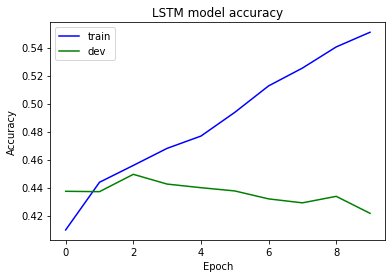

In [65]:
plot_acc(train_acc, dev_acc)

Perhaps needs more epochs.

In [33]:
model = create_model(n_timesteps, n_features, n_hidden, n_classes, dropout = dropout)
model, train_acc, dev_acc = train_model(model, X_train, X_dev, Y_train, Y_dev, epochs = 100, batch_size = 64)

Train on 11628 samples, validate on 3876 samples
Epoch 1/100
11628/11628 [==============================] - 3s 229us/step - loss: 1.1676 - accuracy: 0.4051 - val_loss: 1.1204 - val_accuracy: 0.4040
Epoch 2/100
11628/11628 [==============================] - 2s 183us/step - loss: 1.1129 - accuracy: 0.4321 - val_loss: 1.0976 - val_accuracy: 0.4216
Epoch 3/100
11628/11628 [==============================] - 2s 194us/step - loss: 1.0922 - accuracy: 0.4398 - val_loss: 1.0866 - val_accuracy: 0.4267
Epoch 4/100
11628/11628 [==============================] - 2s 189us/step - loss: 1.0826 - accuracy: 0.4472 - val_loss: 1.0840 - val_accuracy: 0.4218
Epoch 5/100
11628/11628 [==============================] - 2s 179us/step - loss: 1.0736 - accuracy: 0.4467 - val_loss: 1.0812 - val_accuracy: 0.4370
Epoch 6/100
11628/11628 [==============================] - 2s 189us/step - loss: 1.0576 - accuracy: 0.4547 - val_loss: 1.0806 - val_accuracy: 0.4365
Epoch 7/100
11628/11628 [==============================] 

11628/11628 [==============================] - 2s 189us/step - loss: 0.4367 - accuracy: 0.8117 - val_loss: 1.9712 - val_accuracy: 0.4025
Epoch 56/100
11628/11628 [==============================] - 2s 186us/step - loss: 0.4326 - accuracy: 0.8157 - val_loss: 2.0307 - val_accuracy: 0.4043
Epoch 57/100
11628/11628 [==============================] - 2s 180us/step - loss: 0.4247 - accuracy: 0.8191 - val_loss: 2.0588 - val_accuracy: 0.4033
Epoch 58/100
11628/11628 [==============================] - 2s 179us/step - loss: 0.4178 - accuracy: 0.8181 - val_loss: 2.1283 - val_accuracy: 0.4120
Epoch 59/100
11628/11628 [==============================] - 2s 198us/step - loss: 0.4042 - accuracy: 0.8284 - val_loss: 2.0888 - val_accuracy: 0.4056
Epoch 60/100
11628/11628 [==============================] - 2s 186us/step - loss: 0.4102 - accuracy: 0.8255 - val_loss: 2.1319 - val_accuracy: 0.4076
Epoch 61/100
11628/11628 [==============================] - 2s 175us/step - loss: 0.3924 - accuracy: 0.8325 - val

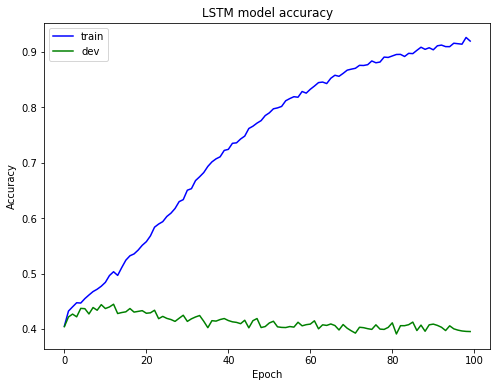

In [34]:
plot_acc(train_acc, dev_acc)

It is clearly overfitting with more epochs, but maybe we can try to reduce the variance. How about increasing dropout?

In [70]:
dropout = 0.8
n_hidden = 100
model = create_model(n_timesteps, n_features, n_hidden, n_classes, dropout = dropout)
model, train_acc, dev_acc = train_model(model, X_train, X_dev, Y_train, Y_dev, epochs = 100, batch_size = 64, verbose = 1)

Train on 11628 samples, validate on 3876 samples
Epoch 1/100
11628/11628 [==============================] - 3s 218us/step - loss: 1.1868 - accuracy: 0.3978 - val_loss: 1.1446 - val_accuracy: 0.4260
Epoch 2/100
11628/11628 [==============================] - 2s 189us/step - loss: 1.1335 - accuracy: 0.4223 - val_loss: 1.1337 - val_accuracy: 0.4420
Epoch 3/100
11628/11628 [==============================] - 2s 185us/step - loss: 1.1222 - accuracy: 0.4175 - val_loss: 1.1301 - val_accuracy: 0.4370
Epoch 4/100
11628/11628 [==============================] - 2s 195us/step - loss: 1.1087 - accuracy: 0.4277 - val_loss: 1.1263 - val_accuracy: 0.4334
Epoch 5/100
11628/11628 [==============================] - 2s 191us/step - loss: 1.0988 - accuracy: 0.4369 - val_loss: 1.1088 - val_accuracy: 0.4476
Epoch 6/100
11628/11628 [==============================] - 2s 209us/step - loss: 1.0927 - accuracy: 0.4409 - val_loss: 1.1138 - val_accuracy: 0.4448
Epoch 7/100
11628/11628 [==============================] 

11628/11628 [==============================] - 2s 185us/step - loss: 0.5173 - accuracy: 0.7792 - val_loss: 1.8633 - val_accuracy: 0.3852
Epoch 55/100
11628/11628 [==============================] - 2s 186us/step - loss: 0.4939 - accuracy: 0.7884 - val_loss: 1.9188 - val_accuracy: 0.3955
Epoch 56/100
11628/11628 [==============================] - 2s 178us/step - loss: 0.4846 - accuracy: 0.7955 - val_loss: 1.8717 - val_accuracy: 0.3798
Epoch 57/100
11628/11628 [==============================] - 2s 183us/step - loss: 0.4645 - accuracy: 0.8014 - val_loss: 1.9765 - val_accuracy: 0.3901
Epoch 58/100
11628/11628 [==============================] - 2s 168us/step - loss: 0.4538 - accuracy: 0.8074 - val_loss: 2.0615 - val_accuracy: 0.3831
Epoch 59/100
11628/11628 [==============================] - 2s 179us/step - loss: 0.4417 - accuracy: 0.8133 - val_loss: 2.0801 - val_accuracy: 0.3831
Epoch 60/100
11628/11628 [==============================] - 2s 190us/step - loss: 0.4401 - accuracy: 0.8130 - val

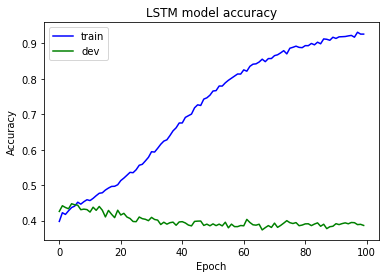

In [71]:
plot_acc(train_acc, dev_acc)

That did not improve our validation error. How about keeping dropout but changing the number of hidden nodes?

In [72]:
dropout = 0.5
n_hidden = 50
model = create_model(n_timesteps, n_features, n_hidden, n_classes, dropout = dropout)
model, train_acc, dev_acc = train_model(model, X_train, X_dev, Y_train, Y_dev, epochs = 100, batch_size = 64, verbose = 1)

Train on 11628 samples, validate on 3876 samples
Epoch 1/100
11628/11628 [==============================] - 2s 179us/step - loss: 1.1979 - accuracy: 0.3941 - val_loss: 1.1191 - val_accuracy: 0.4358
Epoch 2/100
11628/11628 [==============================] - 2s 134us/step - loss: 1.1182 - accuracy: 0.4307 - val_loss: 1.1005 - val_accuracy: 0.4386
Epoch 3/100
11628/11628 [==============================] - 1s 121us/step - loss: 1.0947 - accuracy: 0.4360 - val_loss: 1.0974 - val_accuracy: 0.4347
Epoch 4/100
11628/11628 [==============================] - 2s 134us/step - loss: 1.0759 - accuracy: 0.4547 - val_loss: 1.0883 - val_accuracy: 0.4463
Epoch 5/100
11628/11628 [==============================] - 2s 132us/step - loss: 1.0653 - accuracy: 0.4551 - val_loss: 1.0863 - val_accuracy: 0.4365
Epoch 6/100
11628/11628 [==============================] - 2s 149us/step - loss: 1.0552 - accuracy: 0.4676 - val_loss: 1.0839 - val_accuracy: 0.4401
Epoch 7/100
11628/11628 [==============================] 

11628/11628 [==============================] - 2s 154us/step - loss: 0.5765 - accuracy: 0.7504 - val_loss: 1.6769 - val_accuracy: 0.4027
Epoch 56/100
11628/11628 [==============================] - 2s 134us/step - loss: 0.5677 - accuracy: 0.7540 - val_loss: 1.7322 - val_accuracy: 0.3991
Epoch 57/100
11628/11628 [==============================] - 2s 134us/step - loss: 0.5666 - accuracy: 0.7546 - val_loss: 1.7032 - val_accuracy: 0.4035
Epoch 58/100
11628/11628 [==============================] - 2s 138us/step - loss: 0.5610 - accuracy: 0.7576 - val_loss: 1.7412 - val_accuracy: 0.4007
Epoch 59/100
11628/11628 [==============================] - 2s 139us/step - loss: 0.5478 - accuracy: 0.7648 - val_loss: 1.7507 - val_accuracy: 0.3996
Epoch 60/100
11628/11628 [==============================] - 2s 138us/step - loss: 0.5366 - accuracy: 0.7654 - val_loss: 1.8040 - val_accuracy: 0.3996
Epoch 61/100
11628/11628 [==============================] - 2s 137us/step - loss: 0.5305 - accuracy: 0.7716 - val

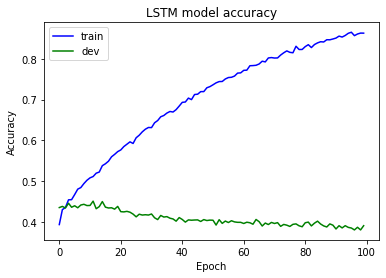

In [73]:
plot_acc(train_acc, dev_acc)

Decreasing number of hidden units may not help either... the other alternative is to get more data. We may have to use multiple regions to train one model. We can first train an individual model for each region to see if any region can get good accuracy. Then we can try combining the regions. If none of those improve performance, then we'll have to look into combining multiple LSTMs.

### One model per region

   Shape of X_train:      (11628, 5, 220)
   Shape of Y_train:           (11628, 4)
     Shape of X_dev:       (3876, 5, 220)
     Shape of Y_dev:            (3876, 4)
    Shape of X_test:       (3876, 5, 220)
    Shape of Y_test:            (3876, 4)


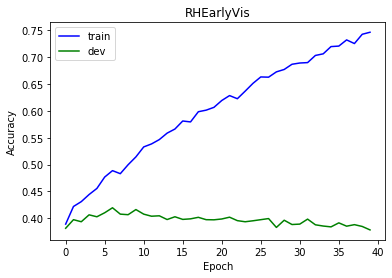

   Shape of X_train:      (11628, 5, 170)
   Shape of Y_train:           (11628, 4)
     Shape of X_dev:       (3876, 5, 170)
     Shape of Y_dev:            (3876, 4)
    Shape of X_test:       (3876, 5, 170)
    Shape of Y_test:            (3876, 4)


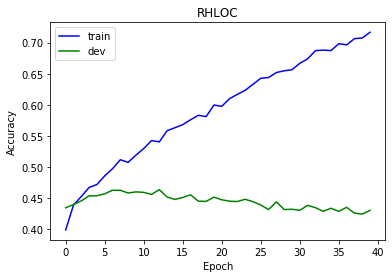

   Shape of X_train:      (11628, 5, 100)
   Shape of Y_train:           (11628, 4)
     Shape of X_dev:       (3876, 5, 100)
     Shape of Y_dev:            (3876, 4)
    Shape of X_test:       (3876, 5, 100)
    Shape of Y_test:            (3876, 4)


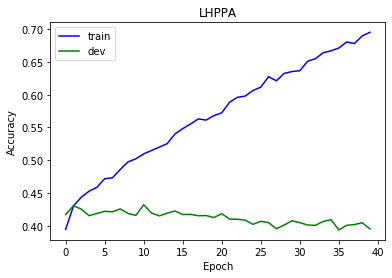

   Shape of X_train:       (11628, 5, 80)
   Shape of Y_train:           (11628, 4)
     Shape of X_dev:        (3876, 5, 80)
     Shape of Y_dev:            (3876, 4)
    Shape of X_test:        (3876, 5, 80)
    Shape of Y_test:            (3876, 4)


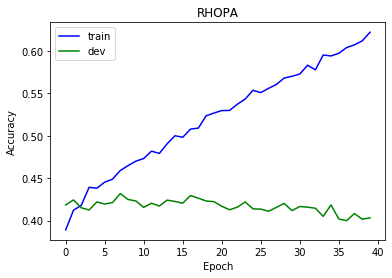

   Shape of X_train:      (12094, 5, 190)
   Shape of Y_train:           (12094, 4)
     Shape of X_dev:       (4031, 5, 190)
     Shape of Y_dev:            (4031, 4)
    Shape of X_test:       (4032, 5, 190)
    Shape of Y_test:            (4032, 4)


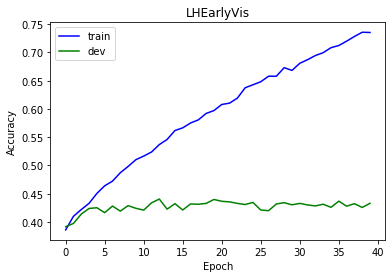

   Shape of X_train:       (11628, 5, 30)
   Shape of Y_train:           (11628, 4)
     Shape of X_dev:        (3876, 5, 30)
     Shape of Y_dev:            (3876, 4)
    Shape of X_test:        (3876, 5, 30)
    Shape of Y_test:            (3876, 4)


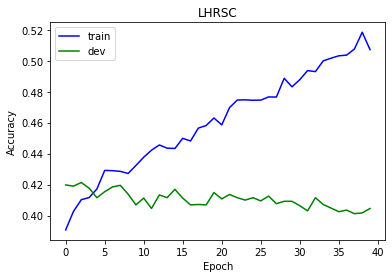

   Shape of X_train:      (11628, 5, 130)
   Shape of Y_train:           (11628, 4)
     Shape of X_dev:       (3876, 5, 130)
     Shape of Y_dev:            (3876, 4)
    Shape of X_test:       (3876, 5, 130)
    Shape of Y_test:            (3876, 4)


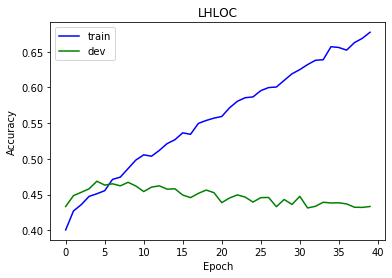

   Shape of X_train:       (11628, 5, 70)
   Shape of Y_train:           (11628, 4)
     Shape of X_dev:        (3876, 5, 70)
     Shape of Y_dev:            (3876, 4)
    Shape of X_test:        (3876, 5, 70)
    Shape of Y_test:            (3876, 4)


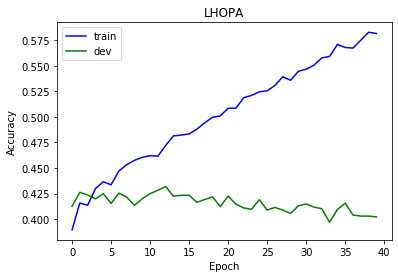

   Shape of X_train:      (11628, 5, 140)
   Shape of Y_train:           (11628, 4)
     Shape of X_dev:       (3876, 5, 140)
     Shape of Y_dev:            (3876, 4)
    Shape of X_test:       (3876, 5, 140)
    Shape of Y_test:            (3876, 4)


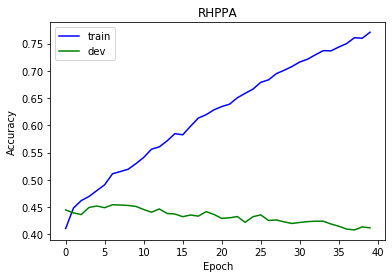

   Shape of X_train:      (11628, 5, 100)
   Shape of Y_train:           (11628, 4)
     Shape of X_dev:       (3876, 5, 100)
     Shape of Y_dev:            (3876, 4)
    Shape of X_test:       (3876, 5, 100)
    Shape of Y_test:            (3876, 4)


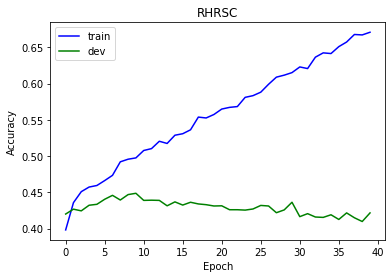

In [74]:
n_hidden = 50
dropout = 0.5
epochs = 40

masks = set([f.split('_')[1][:-4] for f in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir,f)) and '.npy' in f])

region_acc = {}

for mask in masks:   
    X_train, X_dev, X_test, Y_train, Y_dev, Y_test = load_region_data(mask)
    n_timesteps, n_features, n_classes = X_train.shape[1], X_train.shape[2], Y_train.shape[1]

    model = create_model(n_timesteps, n_features, n_hidden, n_classes, dropout = dropout)
    model, train_acc, dev_acc = train_model(model, X_train, X_dev, Y_train, Y_dev, epochs = epochs, batch_size = 64, verbose = 0)
    
    region_acc[mask] = (train_acc[-1], dev_acc[-1])
    
    plot_acc(train_acc, dev_acc, title = mask)

No region looks promising... maybe we could try combining the regional data. Just worried about curse of dimensionality.

### One model for all regions

In [76]:
"""
Load in all the regions
"""
def load_all_data():
    
    masks = set([f.split('_')[1][:-4] for f in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir,f)) and '.npy' in f])

    Y_all = np.load(os.path.join(data_dir,'Y_LHLOC.npy'))
    n_samples = Y_all.shape[0]

    X_all = [np.load(os.path.join(data_dir,'X_' + region + '.npy'))[:n_samples] for region in masks]
    X_all = np.concatenate(X_all, axis = 2)
    
    # Standardize data
    X_scaled = np.array([(x - np.mean(x,axis=1)[:,np.newaxis]) / np.std(x,axis=1)[:,np.newaxis] for x in X_all])
    # Split into train,dev,test
    X_train, X_devtest, Y_train, Y_devtest = train_test_split(X_scaled, Y_all, test_size = 0.4)
    X_dev, X_test, Y_dev, Y_test = train_test_split(X_devtest, Y_devtest, test_size = 0.5)
    
    print('%20s %20s' % ('Shape of X_train:', str(X_train.shape)))
    print('%20s %20s' % ('Shape of Y_train:', str(Y_train.shape)))
    print('%20s %20s' % ('Shape of X_dev:', str(X_dev.shape)))
    print('%20s %20s' % ('Shape of Y_dev:', str(Y_dev.shape)))
    print('%20s %20s' % ('Shape of X_test:', str(X_test.shape)))
    print('%20s %20s' % ('Shape of Y_test:', str(Y_test.shape)))
    
    return X_train, X_dev, X_test, Y_train, Y_dev, Y_test

In [85]:
n_hidden = 100
dropout = 0.5
epochs = 40

X_train, X_dev, X_test, Y_train, Y_dev, Y_test = load_all_data()

n_timesteps, n_features, n_classes = X_train.shape[1], X_train.shape[2], Y_train.shape[1]

model = create_model(n_timesteps, n_features, n_hidden, n_classes, dropout = dropout)
model, train_acc, dev_acc = train_model(model, X_train, X_dev, Y_train, Y_dev, epochs = epochs, batch_size = 64, verbose = 1)

   Shape of X_train:     (11628, 5, 1230)
   Shape of Y_train:           (11628, 4)
     Shape of X_dev:      (3876, 5, 1230)
     Shape of Y_dev:            (3876, 4)
    Shape of X_test:      (3876, 5, 1230)
    Shape of Y_test:            (3876, 4)
Train on 11628 samples, validate on 3876 samples
Epoch 1/40
11628/11628 [==============================] - 7s 609us/step - loss: 1.1779 - accuracy: 0.3801 - val_loss: 1.1243 - val_accuracy: 0.3978
Epoch 2/40
11628/11628 [==============================] - 6s 520us/step - loss: 1.0995 - accuracy: 0.4285 - val_loss: 1.1042 - val_accuracy: 0.4082
Epoch 3/40
11628/11628 [==============================] - 6s 487us/step - loss: 1.0669 - accuracy: 0.4596 - val_loss: 1.0958 - val_accuracy: 0.4177
Epoch 4/40
11628/11628 [==============================] - 6s 479us/step - loss: 1.0254 - accuracy: 0.4832 - val_loss: 1.0948 - val_accuracy: 0.4100
Epoch 5/40
11628/11628 [==============================] - 6s 478us/step - loss: 0.9903 - accuracy: 0.5068 -

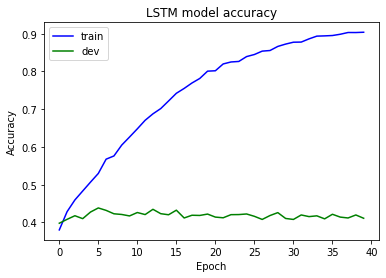

In [86]:
plot_acc(train_acc, dev_acc)

Yikes, no improvement... perhaps we should reconsider our architecture or try to find more data. What classes are we getting wrong?

In [87]:
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(X_test)
matrix = confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1))
print(matrix)

[[671 657 168   2]
 [541 824 173   6]
 [254 312 164   2]
 [ 20  24  13  45]]


Perhaps the class labels are not as orthogonalized as we originally expected. This may be worth revisiting.